# Projeto | Machine Learning I - Problema de Classificação

- Feito por: Kenzo Inanami de Faria | Id: 1116024

## Conjunto de dados

Para esse projeto foi utilizado o conjunto de dados [Machine Failure Predictions](https://www.kaggle.com/datasets/dineshmanikanta/machine-failure-predictions/data) retirado da plataforma Kaggle. Ele é formado por tuplas que representam máquinas com ou sem falhas.
Esse é um conjunto para tarefas de classificação, devemos treinar um modelo para identificar quando uma máquina está com falha.

## Objetivos

Utilizando Scikit-learn, treinar modelos de Random Forest e KNN utilizando técnicas de otimização de hiper-parâmentros, depois, a partir de métricas de avaliação, determinar qual dos modelos performou melhor.


## Importações


### Bibliotecas e classes utilizadas


In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import GridSearchCV

### Conjunto de dados


In [232]:
df = pd.read_csv('machine failure.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


## Análise exploratória dos dados


Para analisar os dados, vamos primeiro entender as variáveis do conjunto:

- UDI e Product ID: São valores de identificação, sendo o primeiro um index para a listagem e Product ID um identificador da máquina.
- Type: Se refere ao tipo da máquina, é uma variável categórica que pode assumir os valores L, M e H.
- Air temperature [K]: Temperatura ambiente ao redor da máquina, em graus Kelvin
- Process temperature [K]: Temperatura do processador, em graus Kelvin
- Rotational speed [rpm]: Velocidade em que a máquina opera, em rotações por minuto
- Torque [Nm]: Força para causar a rotação da máquina, em Newton-metro
- Tool wear: Representa o grau de desgaste que a máquina apresenta devido ao tempo de funcionamento.
- Machine failure: A classe, representa se a máquina apresenta falha(igual a 1) ou não(igual a 0).
- TWF, HDF, PWF, OSF, RNF: É o tipo de falha que a máquina sofreu. também podem ser classes, mas não a especificidade da falha não foi explorada nesse trabalho


In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

O conjunto de dados não apresenta valores nulos.


### Explorando a variável type


Existe um desbalanceamento nos valores que Type pode assumir, possuindo mais máquinas do tipo L.


In [235]:
df['Type'].value_counts(normalize=True)

Type
L    0.6000
M    0.2997
H    0.1003
Name: proportion, dtype: float64

#### O tipo da máquina influência na chance de falhas?


In [236]:
prob_L=len(df[(df['Type'] == 'L') & (df['Machine failure'] == 1)])/len(df[(df['Type'] == 'L')])
prob_M=len(df[(df['Type'] == 'M') & (df['Machine failure'] == 1)])/len(df[(df['Type'] == 'M')])
prob_H=len(df[(df['Type'] == 'H') & (df['Machine failure'] == 1)])/len(df[(df['Type'] == 'H')])

print(f'L: {prob_L}')
print(f'M: {prob_M}')
print(f'H: {prob_H}')

L: 0.03916666666666667
M: 0.02769436102769436
H: 0.020937188434695914


Não foi possível determinar se o tipo influência na quantidade de falhas, pois o resultado pode ter sido afetado pelo desbalanceamento do atributo.

Agora, vamos ver se tipos diferentes de máquinas possuem tipos diferentes de falhas:


In [237]:
df[(df['Type'] == 'L') & (df['Machine failure'] == 1)][['TWF','HDF','PWF','OSF','RNF']]

,TWF,HDF,PWF,OSF,RNF
50,0,0,1,0,0
69,0,0,1,1,0
77,1,0,0,0,0
160,0,0,0,1,0
161,0,0,0,1,0
...,...,...,...,...,...
9758,1,0,0,0,0
9764,0,0,1,0,0
9822,0,0,0,1,0
9830,0,0,0,1,0


In [238]:
df_L = df.loc[df['Type'] == 'L']
df_M = df.loc[df['Type'] == 'M']
df_H = df.loc[df['Type'] == 'H']

In [239]:
def print_errors_freq(df):
	freq = {}
	types_of_error = ['TWF','HDF','PWF','OSF','RNF']

	for error in types_of_error:
		freq[error] = len(df[df[error] == 1])/len(df[df['Machine failure'] == 1])

	freq_sorted = {k: v for k, v in sorted(freq.items(), key=lambda item: item[1], reverse=True)}

	for f in freq_sorted:
		print(f'{f}: {freq[f]}')

In [240]:
print_errors_freq(df_L)

OSF: 0.3702127659574468
HDF: 0.32340425531914896
PWF: 0.251063829787234
TWF: 0.10638297872340426
RNF: 0.05531914893617021


In [241]:
print_errors_freq(df_M)

HDF: 0.37349397590361444
PWF: 0.37349397590361444
TWF: 0.1686746987951807
OSF: 0.10843373493975904
RNF: 0.024096385542168676


In [242]:
print_errors_freq(df_H)

HDF: 0.38095238095238093
TWF: 0.3333333333333333
PWF: 0.23809523809523808
RNF: 0.19047619047619047
OSF: 0.09523809523809523


Analisando as frequências podemos ver que HDF é um tipo frequente em todos os tipos de máquinas. Porém, o resto parece variar de máquina em máquina. É possível concluir que sim, o tipo de máquina influência no tipo de falha.


## Pré-processamento


Primeiro, vamos excluir o index e o identificador:


In [243]:
df['UDI'].nunique()

10000

In [244]:
df['Product ID'].nunique()

10000

In [245]:
df.drop(['UDI','Product ID'],axis=1,inplace=True)
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


Aqui foi feito uma verificação final para ver se a variável Type seria mantida. Eu queria verificar se, para tipos diferentes de máquinas, os valores dos atributos possuiam uma média e variância significativamente diferentes para os casos de bom funcionamento ou com falhas.


In [246]:
att = ['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

aux = [df_L[att].mean().values,
       df_L[df_L['Machine failure'] == 1][att].mean().values,
       df_L[att].std().values,
       df_L[df_L['Machine failure'] == 1][att].std().values]
df_L_att = pd.DataFrame(aux,index=['mean','mean_has_failure','std','std_has_failure'],columns=att)
df_L_att

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
mean,300.015833,310.012300,1539.469167,39.996600,108.378833
mean_has_failure,300.756596,310.248511,1482.408511,50.785106,148.889362
std,1.987453,1.475247,180.428518,10.012335,64.058238
std_has_failure,2.086994,1.356635,373.927371,15.846539,72.445828


In [247]:
aux = [df_M[att].mean().values,
       df_M[df_M['Machine failure'] == 1][att].mean().values,
       df_M[att].std().values,
       df_M[df_M['Machine failure'] == 1][att].std().values]
df_M_att = pd.DataFrame(aux,index=['mean','mean_has_failure','std','std_has_failure'],columns=att)
df_M_att

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
mean,300.029263,310.018785,1537.598932,40.017251,107.272272
mean_has_failure,301.186747,310.402410,1550.036145,48.242169,129.289157
std,2.017358,1.498407,179.059828,9.992153,63.044646
std_has_failure,1.993023,1.359158,434.840606,18.415702,72.315624


In [248]:
aux = [df_H[att].mean().values,
       df_H[df_H['Machine failure'] == 1][att].mean().values,
       df_H[att].std().values,
       df_H[df_H['Machine failure'] == 1][att].std().values]
df_H_att = pd.DataFrame(aux,index=['mean','mean_has_failure','std','std_has_failure'],columns=att)
df_H_att

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
mean,299.866999,309.925723,1538.147557,39.838285,107.419741
mean_has_failure,301.152381,310.314286,1442.380952,50.876190,143.904762
std,2.021831,1.489362,173.133428,9.642339,63.080140
std_has_failure,2.150725,1.499095,275.313181,13.506291,73.776626


O que pude concluir a partir disso, é que diferentes tipos de máquina apresentam falhas em situações muito parecidas. Ou seja, é um atributo a ser excluído do processamento.

Além disso, os tipos específicos de falhas foram excluídos, pois trabalharei com o valor geral 'Machine failures' como chave.


In [249]:
df.drop(['TWF','HDF','PWF','OSF','RNF','Type'],axis=1,inplace=True)

#### Normalização


In [250]:
from sklearn.preprocessing import StandardScaler

In [251]:
scaler = StandardScaler()
df_normalized = df.copy()
df_normalized[att] = pd.DataFrame(scaler.fit_transform(df[att]), columns=att)

In [252]:
df_normalized

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984,0
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,0
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,0
3,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009,0
4,-0.902393,-0.879959,-0.729472,0.001313,-1.554588,0
...,...,...,...,...,...,...
9995,-0.602417,-1.082162,0.363820,-1.052012,-1.476034,0
9996,-0.552421,-1.082162,0.520005,-0.821283,-1.428902,0
9997,-0.502425,-0.947360,0.592519,-0.660777,-1.350349,0
9998,-0.502425,-0.879959,-0.729472,0.854005,-1.303217,0


Podemos notar um desbalanceamento significativo entre os valores da classe, existem muito mais casos de máquinas sem falha do que com falha. Então para cada algoritmo usarei uma técnica para tratar isso.


In [253]:
df_normalized_mf = df_normalized[df_normalized['Machine failure'] == 1]
print(len(df_normalized)-len(df_normalized_mf))

9661


#### Separando os atributos da classe


In [254]:
X = df.drop('Machine failure',axis=1)
y = df['Machine failure']

## KNN


Para o KNN aplicarei as técnicas de Random Under-Sampling e depois Random Over-Sampling, no final verificando qual delas foi a melhor para o caso.


### Under-Sampling


No under-sampling, diminuímos a quantidade de entradas de máquinas em bom funcionamento para a quantidade se igualar a de máquinas com falha.


In [256]:
rus = RandomUnderSampler(sampling_strategy=1, random_state=51)
X_res, y_res = rus.fit_resample(X, y)
print('Balanceamento de classe: ')
print(y_res.value_counts())
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_res, y_res, test_size=0.2, random_state=1)

Balanceamento de classe: 
Machine failure
0    339
1    339
Name: count, dtype: int64


Para encontrar o melhor k para o KNN vamos fazer testes com valores de 1 a 70, usando o erro médio como medida:


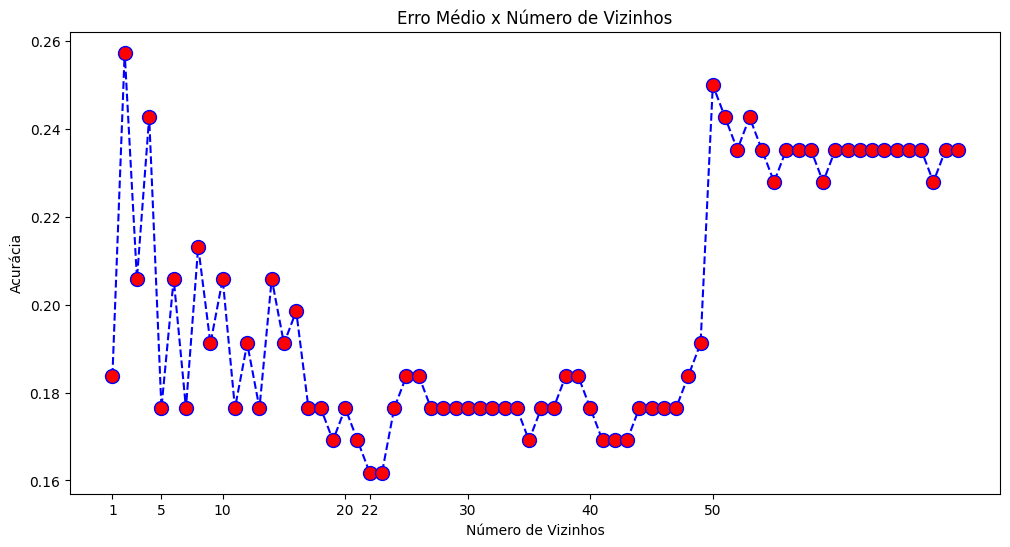

In [299]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
errors = []
k = 70

for i in range(1,k+1):
	knn = KNeighborsClassifier(n_neighbors=i)
	knn.fit(X_train_us,y_train_us)
	y_pred = knn.predict(X_test_us)
	errors.append(np.mean(y_pred != y_test_us))

plt.figure(figsize=(12, 6))
plt.plot(range(1, k+1), errors, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Erro Médio x Número de Vizinhos')
plt.xticks([1,5,10,20,22,30,40,50])

plt.xlabel('Número de Vizinhos')
plt.ylabel('Acurácia')
plt.show()

Para a minimização do erro médio, o melhor k encontrado é o 22 para o caso com under-sampling.


In [300]:
print(min(errors))
print(errors.index(min(errors))+1)

0.16176470588235295
22


### Over-Sampling


No over-sampling ocorre oposto, geramos mais entradas de máquinas com falhas para se igualar a de máquinas sem falha.


In [259]:
ros = RandomOverSampler(sampling_strategy=1,random_state=2)
X_res, y_res = ros.fit_resample(X, y)
print('Balanceamento de classe: ')
print(y_res.value_counts())
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_res, y_res, test_size=0.2, random_state=1)

Balanceamento de classe: 
Machine failure
0    9661
1    9661
Name: count, dtype: int64


Usaremos a mesma técnica que anteriormente para encontrar o melhor valor de k:


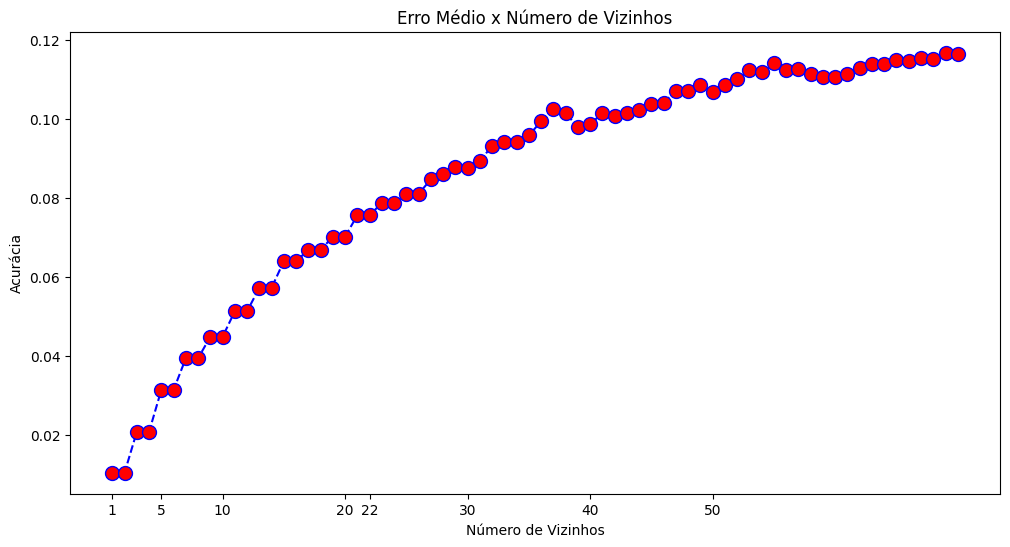

In [260]:
errors = []
k = 70

for i in range(1,k+1):
	knn = KNeighborsClassifier(n_neighbors=i)
	knn.fit(X_train_os,y_train_os)
	y_pred = knn.predict(X_test_os)
	errors.append(np.mean(y_pred != y_test_os))

plt.figure(figsize=(12, 6))
plt.plot(range(1, k+1), errors, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Erro Médio x Número de Vizinhos')
plt.xticks([1,5,10,20,22,30,40,50])

plt.xlabel('Número de Vizinhos')
plt.ylabel('Acurácia')
plt.show()

In [261]:
print(min(errors))
print(errors.index(min(errors))+1)

0.01034928848641656
1


Aqui encontramos um comportamento estranho, a conclusão tirada foi que para casos onde o desbalanceamento é muito grande, a geração de novos casos para compensar se torna mais complexa. Foram gerados tantos casos novos que eles começaram a ficar muito repetitivos, assim é como se treinassemos e testassemos o modelo com o mesmo conjunto.

Por isso, para melhor versão de modelo escolhi o aquele treinado com under-sampling e k=22:


In [301]:
knn = KNeighborsClassifier(n_neighbors=22)
knn.fit(X_train_us,y_train_us)
y_pred = knn.predict(X_test_us)

In [302]:
print("Matriz de Confusão: ")
print(confusion_matrix(y_test_us, y_pred), "\n")  

print("Métricas de classificação: \n", classification_report(y_test_us, y_pred))  

print('Acurácia:' , accuracy_score(y_test_us, y_pred))

Matriz de Confusão: 
[[50  6]
 [16 64]] 

Métricas de classificação: 
               precision    recall  f1-score   support

           0       0.76      0.89      0.82        56
           1       0.91      0.80      0.85        80

    accuracy                           0.84       136
   macro avg       0.84      0.85      0.84       136
weighted avg       0.85      0.84      0.84       136

Acurácia: 0.8382352941176471


## Random Forest


Para compensar o desbalanceamento de classe, utilizarei pesos diferentes para cada classe. Quando o hiper-parâmetro class_weight é igual a 'balanced', o modelo fará com que o peso da classe seja inversamente proporcional a sua frequência, nesse caso, errar quando a máquina tem uma falha possui mais peso do que errar para uma máquina em bom funcionamento.

Para encontrar os melhores hiper-parâmetros foi utilizado o algoritmo do grid search para testar para todos os casos.


In [287]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

param_grid = {
        'n_estimators':[50,75,100],
	'criterion': ['gini','entropy'],
	'max_depth': [None, 5, 10, 15],
	'min_samples_split': [2, 3, 5],
	'min_samples_leaf': [1,3],
	'class_weight':['balanced']
}


grid_search = GridSearchCV(
	estimator=RandomForestClassifier(),
	param_grid= param_grid,
	cv = 5
)


grid_search.fit(X_train,y_train)

best_params = grid_search.best_params_
print(best_params)

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 75}


In [289]:
rf = RandomForestClassifier(class_weight='balanced',
                            criterion = 'entropy',
                            max_depth= None,
                            min_samples_leaf= 3,
                            min_samples_split= 2,
                            n_estimators= 75)

rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

In [290]:
print("Matriz de Confusão: ")
print(confusion_matrix(y_test, y_pred), "\n")  

print("Métricas de classificação: \n", classification_report(y_test, y_pred))  

print('Acurácia:' , accuracy_score(y_test, y_pred))

Matriz de Confusão: 
[[1926   11]
 [  16   47]] 

Métricas de classificação: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1937
           1       0.81      0.75      0.78        63

    accuracy                           0.99      2000
   macro avg       0.90      0.87      0.88      2000
weighted avg       0.99      0.99      0.99      2000

Acurácia: 0.9865


## Conclusão

O melhor modelo do experimento foi o KNN, apesar do Random Forest possuir melhor acurácia, ela é devida ao desbalanceamento da classe. No quesito das métricas, o KNN obteve melhor precisão e recall para classificar máquinas defeituosas, possuindo a mesma quantidade de falsos positivos mas uma quantidade menor de falsos negativos. O mais importante era classificar corretamente as máquinas defeituosas, evitando que uma máquina com defeito entre em funcionamento possivelmente causando algum acidente ou que uma máquinas sem defeito passe por uma manutenção desnecessária e o modelo que melhor fez isso foi o KNN. Porém, é importante ressaltar que ele foi treinado com uma quantidade muito inferior de dados que o Random Forest, assim sendo possível que ele não é o mais generalizado.
